In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-12 11:57:36.292752


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-3.2435)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(4.3682)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(36.2062)
train_loss:  -5.766029483795166
valid_loss:  -4.7888727977752685
h_min_tilde -6.1621222 ell_tilde -5.570598146591186 kappa_tilde 0.0013002108241149158
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -2.497779440903664
valid_loss:  -2.1881857975721357
weight_alpha 1.0 h_min_tilde -6.1621222 ell_tilde -2.4358607122373583 kappa_tilde 0.0005180400458485414


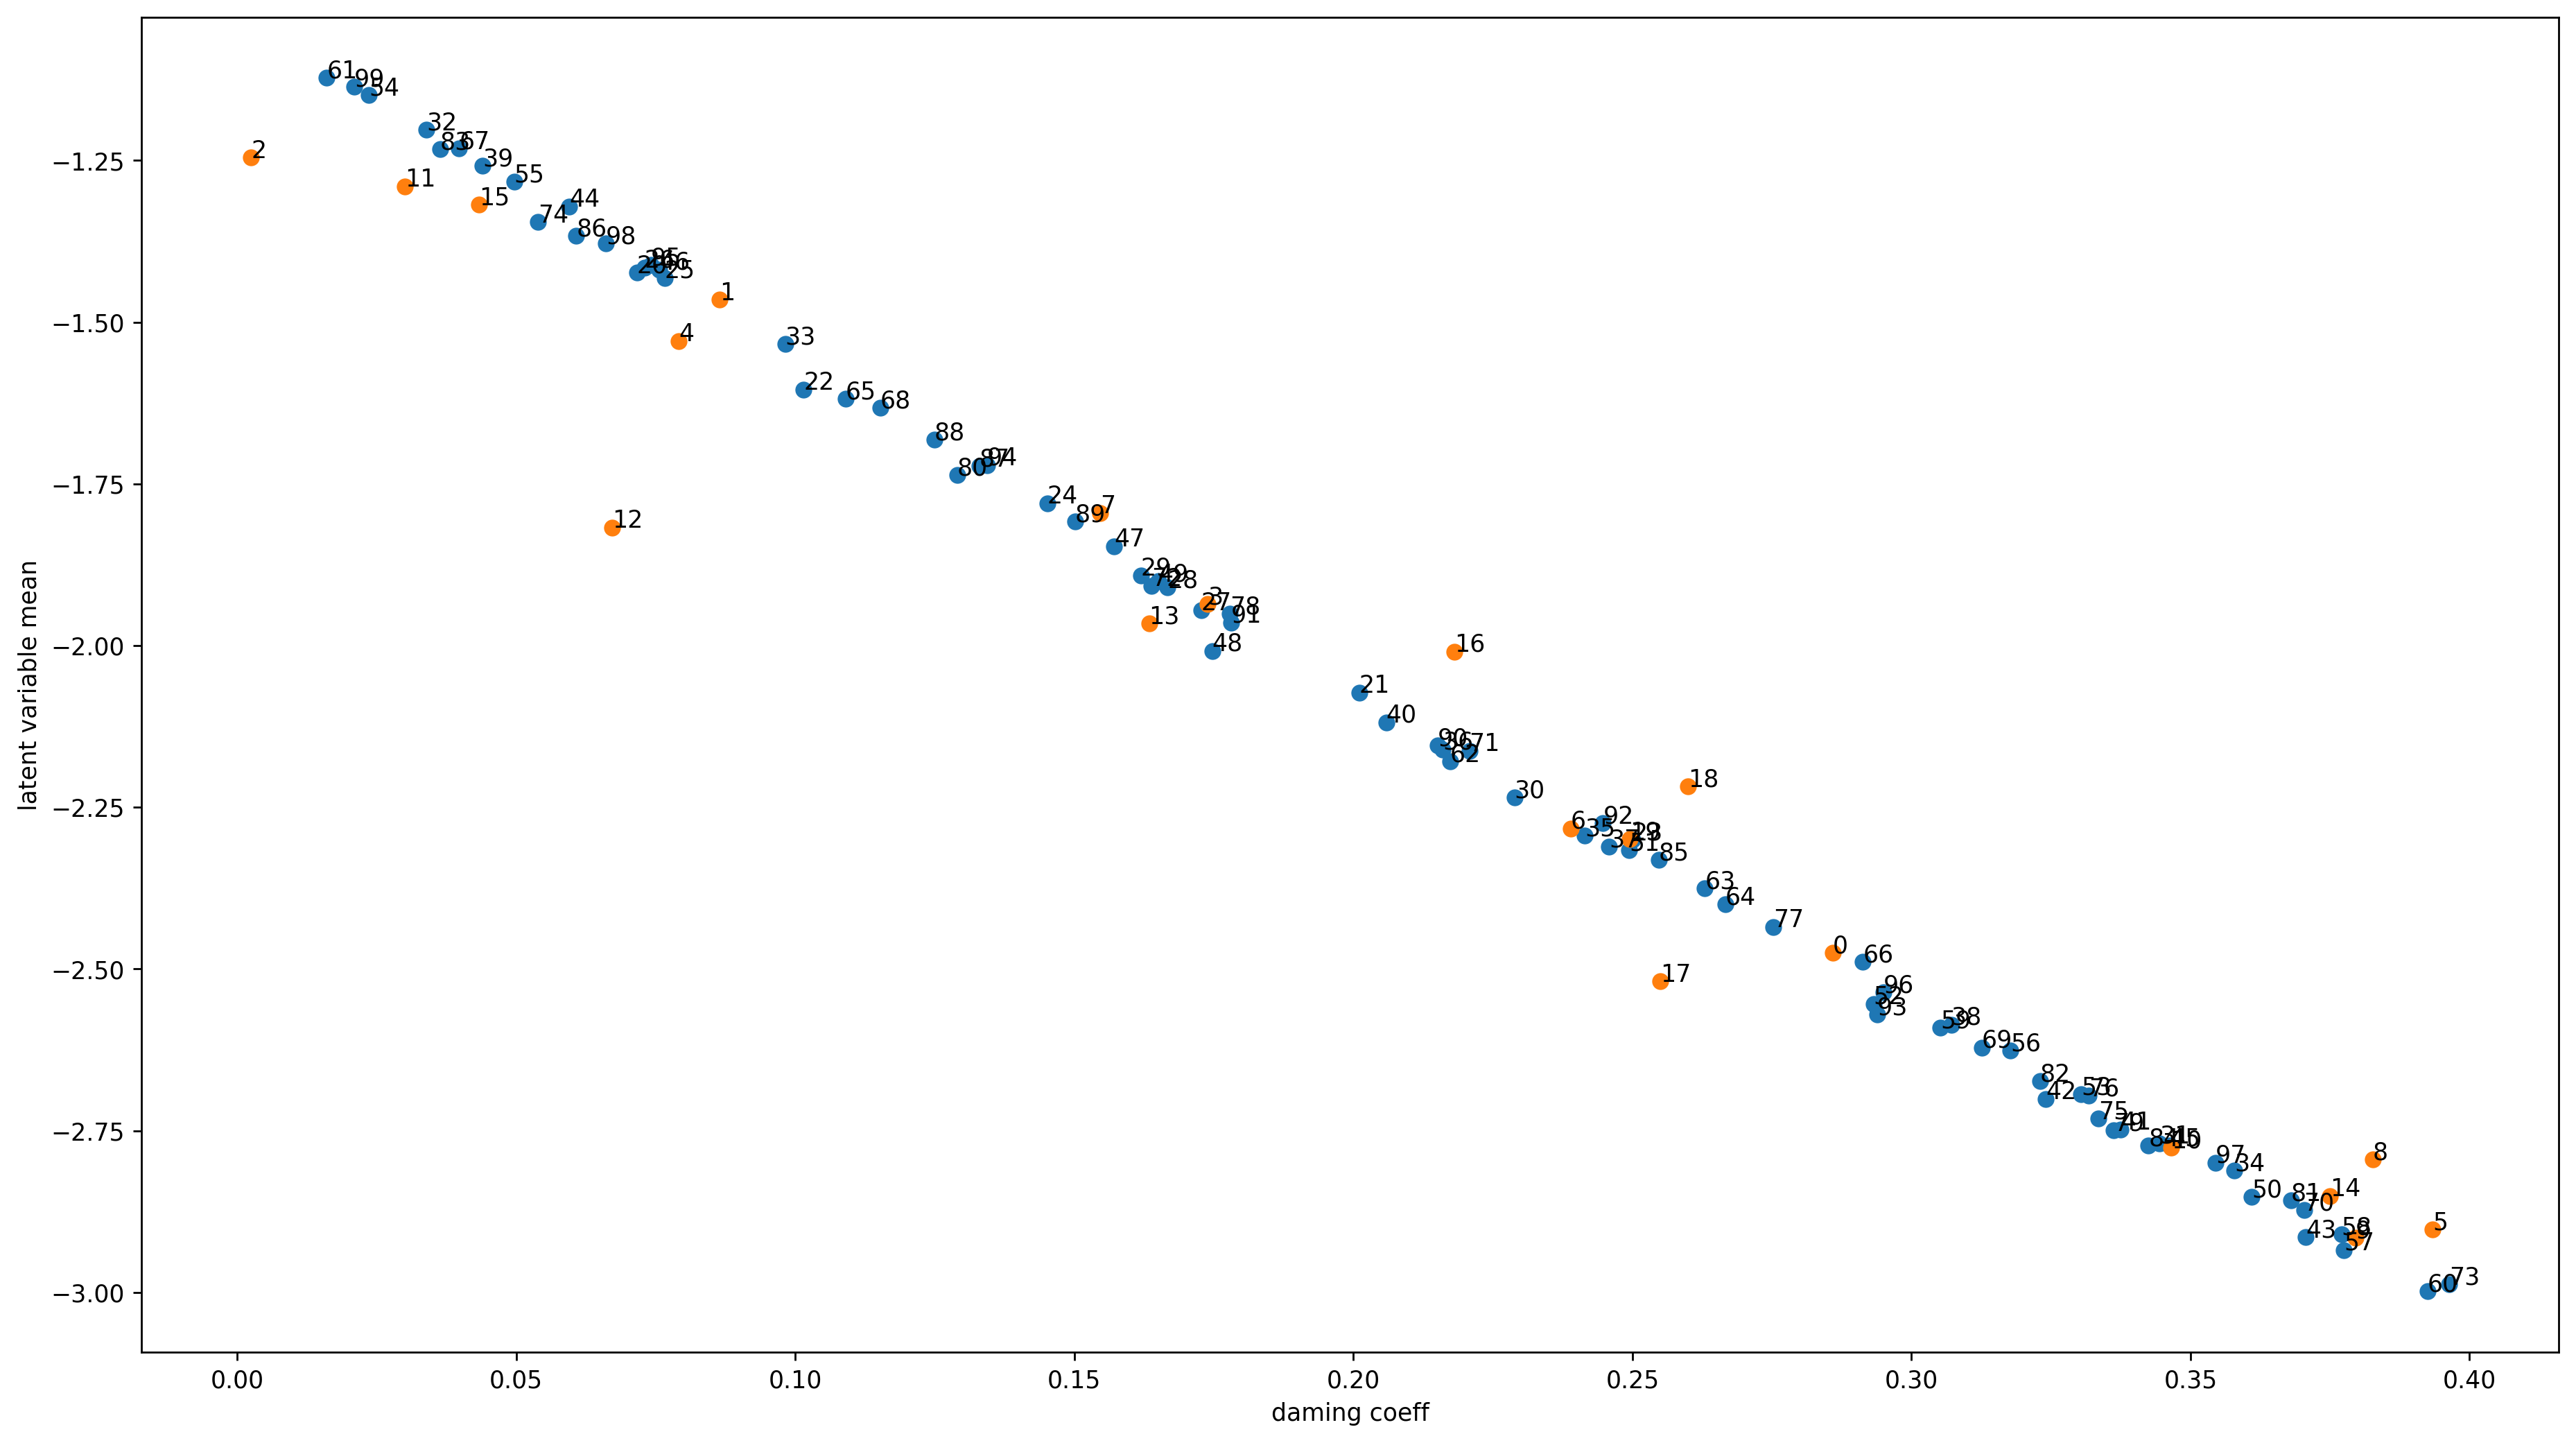

[0.2859264  0.0864358  0.0024921  0.17391661 0.07907403 0.39336027
 0.23893358 0.15462851 0.38266119 0.37959092]
[0.34651572 0.02997943 0.06718887 0.16337754 0.37502863 0.04327735
 0.21808106 0.2550441  0.25992204 0.24956645]
[0.07158956 0.20101322 0.10147186 0.24997234 0.14514144 0.07657856
 0.07297816 0.17272883 0.16671052 0.16193009]
[0.22885551 0.34440572 0.03386464 0.09818148 0.35786052 0.2414254
 0.21602989 0.24582514 0.30710321 0.04392725]
[0.20586148 0.3374828  0.32405777 0.37068828 0.05949074 0.34630997
 0.0756103  0.15711247 0.17470652 0.16498888]
[0.36096874 0.24942754 0.29319949 0.33040915 0.02355204 0.04960585
 0.31776933 0.377519   0.37703434 0.30519746]
[0.39248397 0.01603645 0.21731613 0.26299385 0.26662336 0.10898858
 0.29130778 0.03973111 0.11521473 0.31261245]
[0.37032344 0.22077058 0.16383656 0.39631873 0.05390104 0.33351255
 0.33176718 0.27528851 0.17781627 0.33618643]
[0.12902999 0.36799494 0.32301958 0.03636422 0.34247351 0.25473947
 0.06075424 0.13299807 0.12488

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 4.227073669433594

 2 3.162713050842285

 3 3.2288475036621094

 4 3.320056200027466

 5 3.2810678482055664

 6 3.2461485862731934

 7 3.2370107173919678

 8 3.1885836124420166

 9 3.141843557357788

 10 3.1951234340667725

 11 3.3236401081085205

 12 3.460402250289917

 13 3.3852624893188477

 14 2.8493282794952393

 15 3.3023903369903564

 16 3.2762928009033203

 17 3.358508825302124

 18 3.19002103805542

 19 3.0979907512664795

 20 3.123939275741577

 21 3.089745044708252

 22 3.075854539871216

 23 3.1532514095306396

 24 3.578052043914795

 25 3.3255109786987305

 26 3.33686900138855

 27 3.2081472873687744

 28 3.278247356414795

 29 3.2744715213775635

 30 3.332002639770508

 31 3.2457685470581055

 32 3.2706854343414307

 33 3.038222312927246

 34 3.2031500339508057

 35 3.2024877071380615

 36 3.120347738265991

 37 3.1135315895080566

 38 3.085233688354492

 39 3.1540520191192627

 40 3.2092230319976807

 41 3.1611742973327637

 42 2.8460960388183594

 43 3.4843037128448

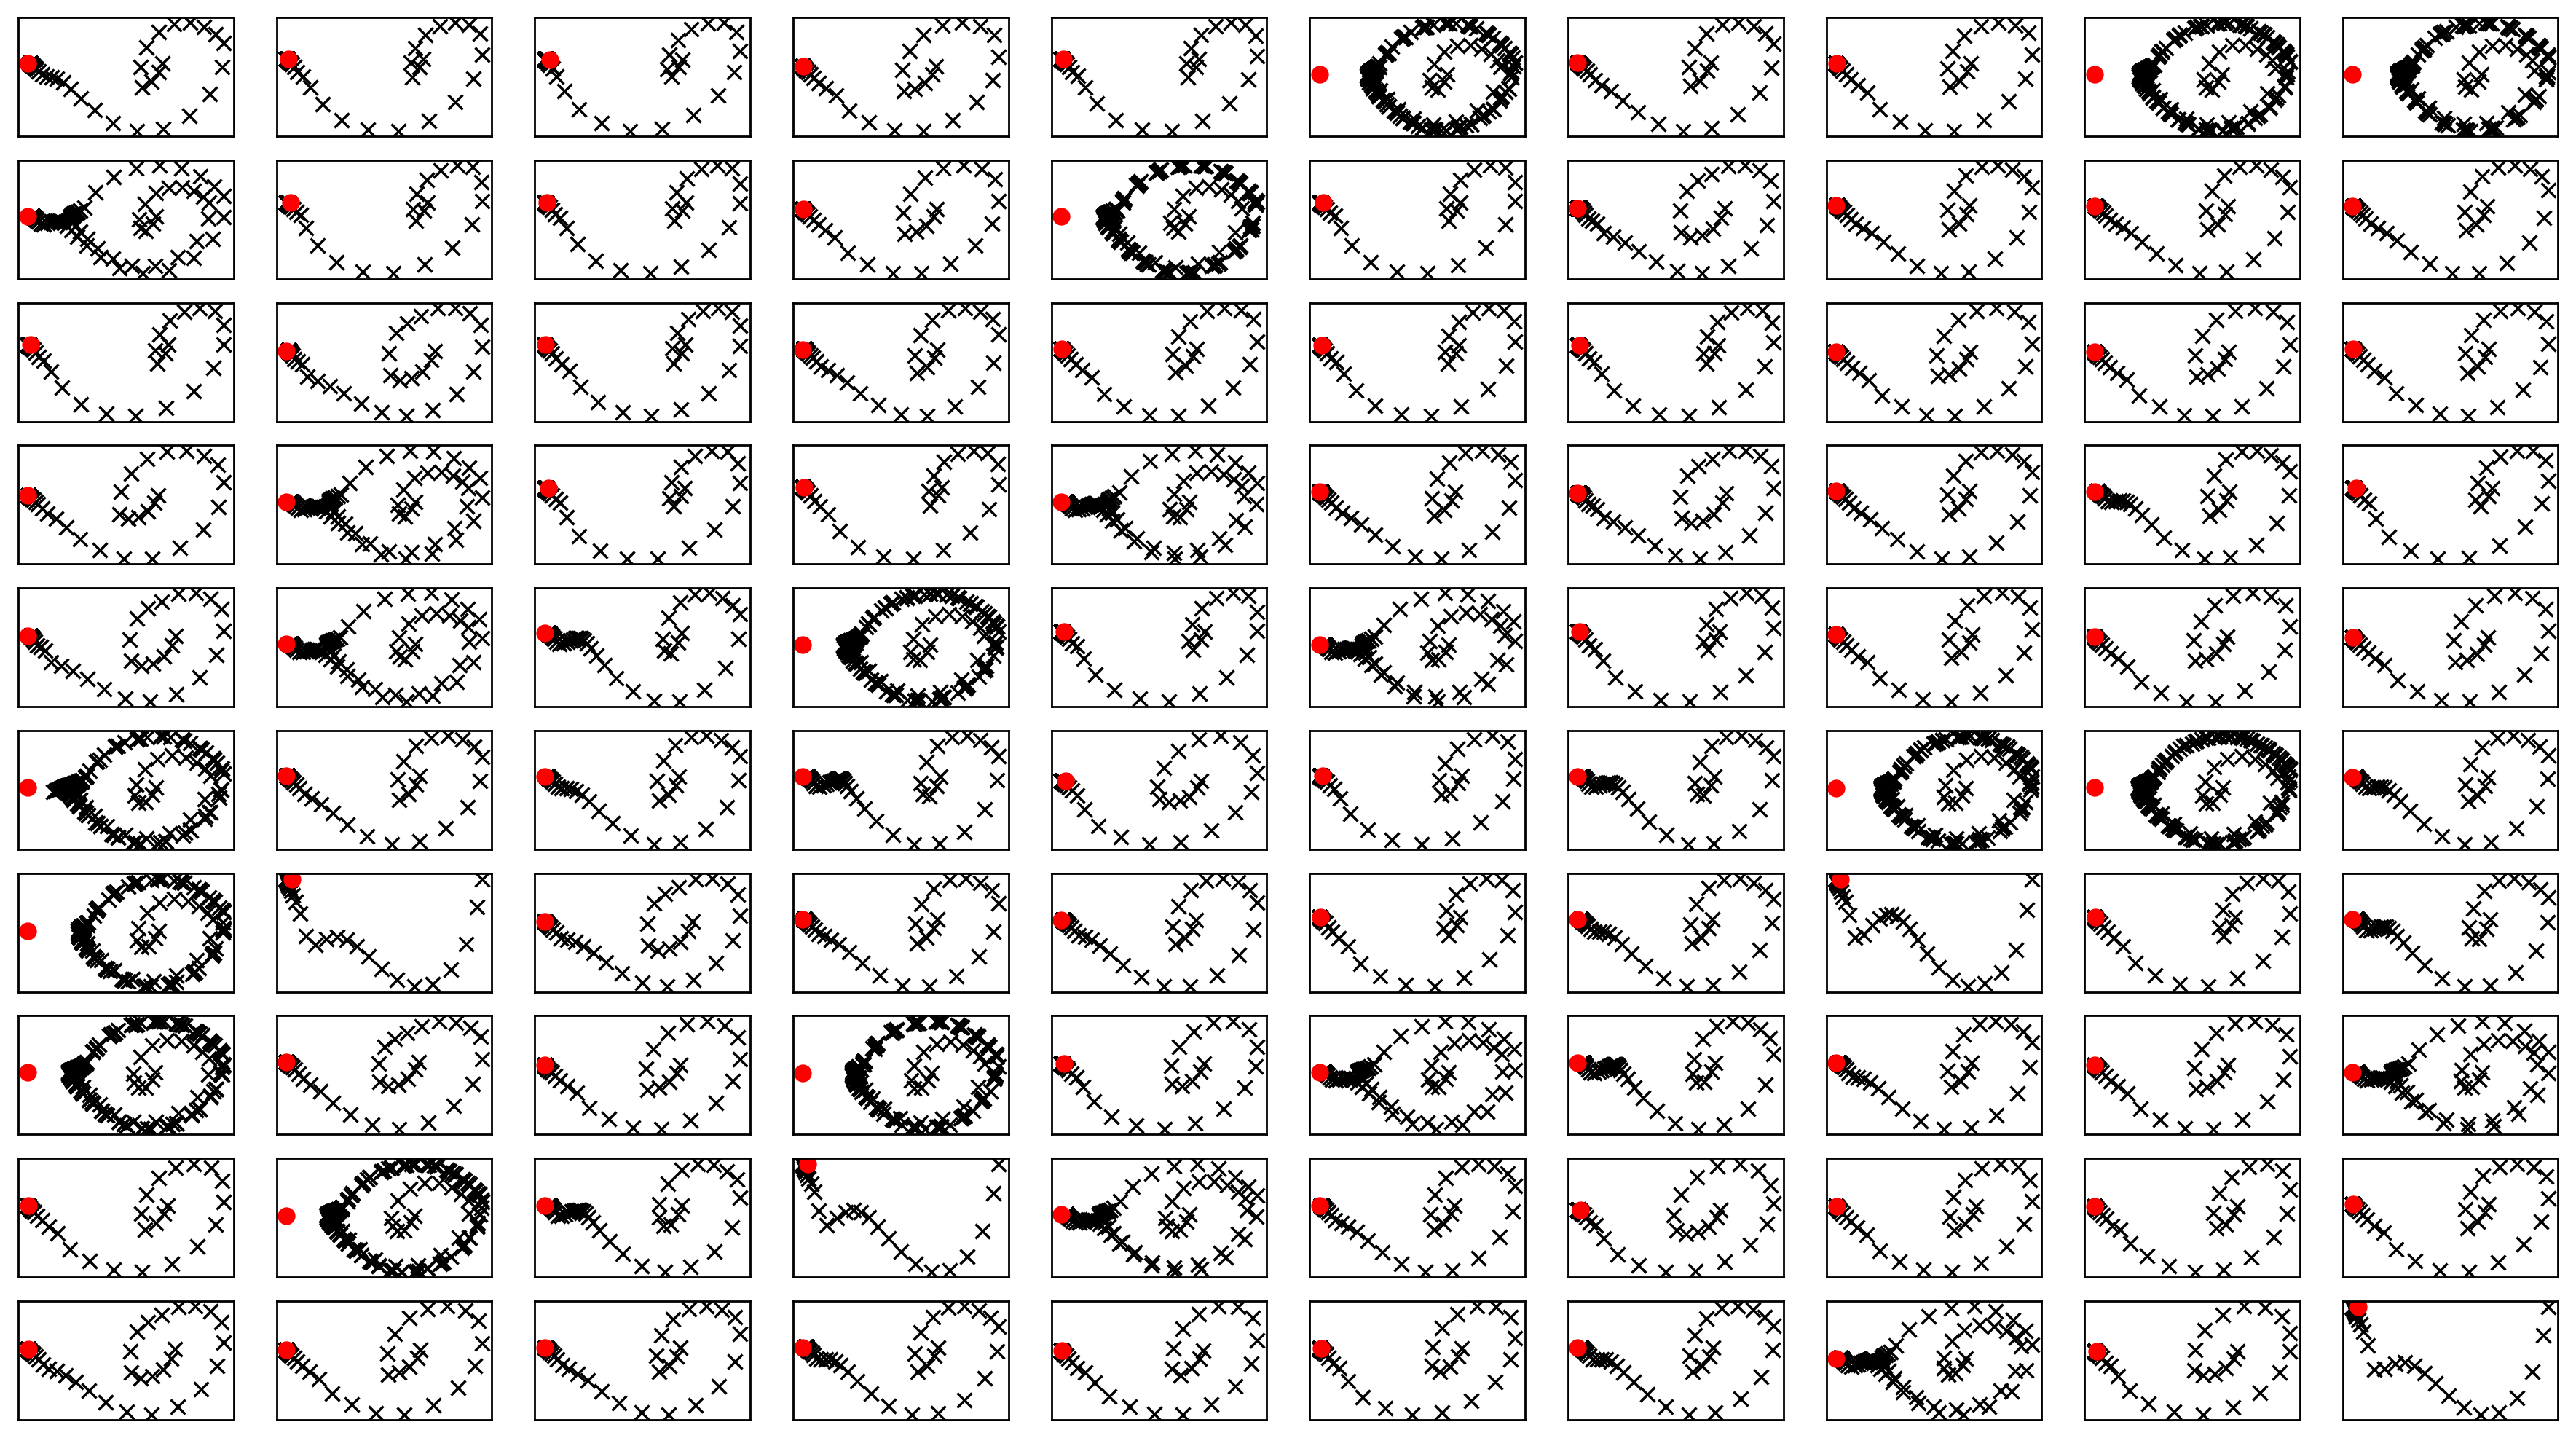

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [ ]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.0509681701660156

 2 3.3484320640563965

 3 3.191133737564087

 4 3.0952131748199463

 5 3.1721434593200684

 6 3.3084890842437744

 7 3.250204086303711

 8 3.285930871963501

 9 4.7666614055633545

 10 3.850548505783081

 11 3.5494749546051025

 12 3.238016128540039

 13 3.4985079765319824

 14 3.3193538188934326

 15 3.1430306434631348

 16 3.0796730518341064

 17 3.3161375522613525

 18 3.5882205963134766

 19 3.320890426635742

 20 3.238050699234009

 21 3.186312675476074

 22 3.0900111198425293

 23 3.221369743347168

 24 3.3034207820892334

 25 2.7143490314483643

 26 3.309929132461548

 27 3.3673856258392334

 28 3.1137123107910156

 29 3.2340736389160156

 30 3.30912446975708

 31 3.273481845855713

 32 3.233691453933716

 33 3.5003955364227295

 34 3.4561870098114014

 35 3.187624216079712

 36 2.9661526679992676

 37 3.100881338119507

 38 3.3613831996917725

 39 3.5548126697540283

 40 3.1495566368103027

 41 3.117434501647949

 42 3.1032633781

In [ ]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [ ]:
print(datetime.datetime.now())